The data consist of today's return, today's close, and today's volume.

In [1]:
import numpy as np
X = np.load('zipped_zrxeth.npy')
Vols = X[:-1,-1].copy()

#X

In [2]:
X[:,-1] = X[:,-1]/1000.0
X[:,-1]=np.log(X[:,-1]+1e-6)/1000
#X

In [3]:
#np.std(X[:,-1]),np.std(X[:,0])

(0.003167335779072404, 0.002549075748767973)

Features include past 5 days return sequence, past 5 days price range, and past 5 days sum volume(log scaled).

In [4]:
XX=[]
w = 5
for i in range(int(len(X)/w)):
    #x = list(X[i*w:w*i+w,0])
    x=[sum(X[i*w:i*w+w,0])*1.0]
    x+=[(max(X[i*w:i*w+w,1])-min(X[i*w:i*w+w,1]))]
    x+=[sum(X[i*w:i*w+w,-1])*1.0]
    XX.append(x)
#XX

In [5]:
Mins = np.load('Mins_zrxeth.npy')
Mins = Mins[:-1]

In [6]:
Close = np.load('close_zrxeth.npy')
Close=Close[:-1]

In [7]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from hmmlearn import hmm
warnings.filterwarnings('ignore')
np.random.seed(10)
model = hmm.GaussianHMM(n_components=10, covariance_type="full", min_covar=0.0,verbose=True,n_iter=100)
model.fit(XX)  
model.monitor_  

         1       47027.6752             +nan
         2       30647.7498      -16379.9253


ConvergenceMonitor(history=[47027.6751731665, 30647.74983032215], iter=2,
          n_iter=100, tol=0.01, verbose=True)

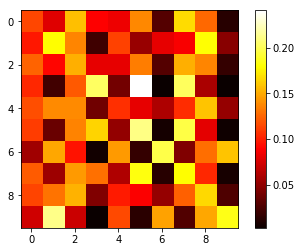

In [8]:
from matplotlib import pyplot as plt
from matplotlib.colors import PowerNorm

%matplotlib inline
plt.imshow(model.transmat_, cmap='hot', interpolation='nearest')
plt.colorbar()

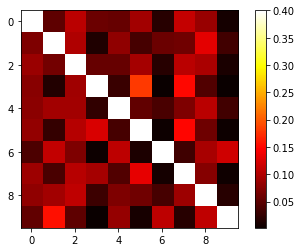

In [9]:

for s in range(model.n_components):
    p = max(0.4,np.max(model.transmat_[s]))
    if model.transmat_[s][s]>=p:
        pass
    else:
        denom = sum(model.transmat_[s])-model.transmat_[s][s]
        model.transmat_[s]/=denom
        model.transmat_[s]*=1-p
        model.transmat_[s][s] = p
plt.imshow(model.transmat_, cmap='hot', interpolation='nearest')
plt.colorbar()

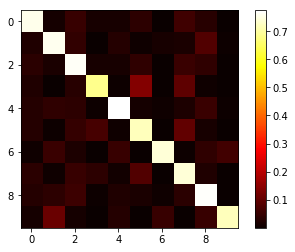

In [10]:
for s in range(model.n_components):
    model.transmat_[s] = model.transmat_[s]**2
    model.transmat_[s]/=sum(model.transmat_[s])
plt.imshow(model.transmat_, cmap='hot', interpolation='nearest')
plt.colorbar()

In [11]:
ZZ = model.predict(XX)

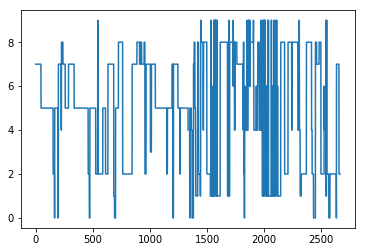

In [12]:
plt.plot(ZZ)

In [13]:
len(XX),len(ZZ)

(2666, 2666)

In [14]:
len(Mins),len(Close)

(13330, 13330)

In [15]:
Z=[]
for i in ZZ:
    Z+=[i]*w
print len(Z)
Z = np.array(Z)

13330


In [16]:

print("Transition matrix")
print(model.transmat_)
print()
from matplotlib import cm
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()



Transition matrix
[[7.59047552e-01 1.34928233e-02 5.42406501e-02 1.75853069e-02
  1.52916514e-02 4.13931145e-02 1.80245465e-03 6.15380315e-02
  3.52124248e-02 3.95991123e-04]
 [2.44395771e-02 7.61446723e-01 4.77935403e-02 1.19710830e-03
  3.23569724e-02 7.29216413e-03 1.69265048e-02 1.94644560e-02
  8.33389803e-02 5.74397331e-03]
 [3.74828395e-02 1.98896333e-02 7.65240894e-01 1.57702109e-02
  1.57022342e-02 4.32262443e-02 1.98840259e-03 5.49068018e-02
  4.50297458e-02 7.62993400e-04]
 [2.58957031e-02 1.26480736e-03 3.58496738e-02 6.84476013e-01
  3.93373348e-03 1.40526093e-01 1.81834840e-05 9.94346073e-02
  8.57201687e-03 2.91688371e-05]
 [3.02958343e-02 4.23710415e-02 4.18536643e-02 3.42725029e-03
  7.74307510e-01 1.43469398e-02 7.96246345e-03 2.41671866e-02
  5.52965232e-02 5.97158674e-03]
 [3.20615454e-02 3.45441605e-03 4.85245509e-02 7.06439545e-02
  6.85864004e-03 7.20391522e-01 1.16289331e-04 1.01041808e-01
  1.68435915e-02 6.36820243e-05]
 [8.28730378e-03 5.73954871e-02 2.381115

In [20]:
Ret = X[:,0]
log_Ret = np.log(Ret+1.0)
def score_plot(Mins,Close,Vols,Ret,Z,n_comp,th=0.5,fee=0.005):
    end = []
    Seg = []
    plt.figure()
    for i in range(n_comp):
        cur = [0]
        seg = 0
        flag= False
        for j in range(len(Z)):
            if i == Z[j]:
                if not flag:
                    seg+=1
                    flag = True
                cur.append(cur[-1]+Ret[j])
            else:
                if flag:
                    flag=False
                cur.append(cur[-1])
        end.append(cur[-1])
        Seg.append(seg)
        plt.plot(Mins,cur[1:],label='Z='+str(i)+' '+str(cur[-1]))
    plt.legend(loc='upper left')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Log Return')
    plt.figure()
    fig, ax1 = plt.subplots(figsize=(20,6))
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('eth-btc', color=color)
    ax1.plot(Mins, Close, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
    ax2.plot(Mins, Vols, color=color)
    ax2.set_ylim(0,1000)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout() 
    score_up = 0
    score_down = 0
    score_none = 0
    tseg = sum(Seg)
    #fee=0.005
    for i in range(n_comp):

        if end[i]<th*max(end) and end[i]>th*min(end):
            score_none+=end[i]
            ax1.plot(Mins[Z==i],Close[Z==i],'bo',markersize=1)
        elif end[i]>=th*max(end):
            score_up+=end[i]-fee*Seg[i]
            ax1.plot(Mins[Z==i],Close[Z==i],'ro',markersize=3)
        else:
            score_down+=abs(end[i])-fee*Seg[i]
            ax1.plot(Mins[Z==i],Close[Z==i],'go',markersize=3)
    score = score_up+score_down-abs(score_none)
    print 'Score:'+str(score)
    return score,Seg

Score:2.466930388652556


(2.466930388652556, [11, 27, 19, 1, 20, 13, 36, 16, 23, 29])

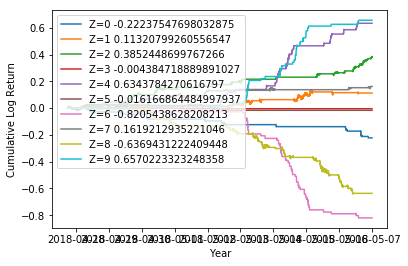

<Figure size 432x288 with 0 Axes>

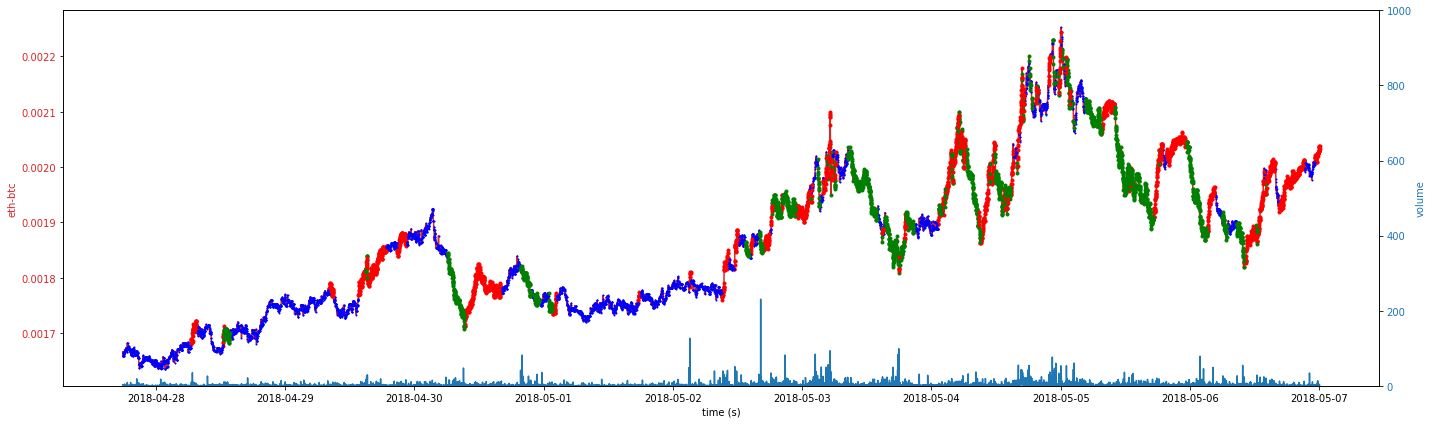

In [23]:
score_plot(Mins,Close,Vols,Ret,Z,model.n_components,th=0.5,fee=0.005)

### Results:
#### p threshold = 0.9:  Score = 1.119
####            = 0.7:  Score = 1.537
####            = 0.5:  Score = 2.016
####            = 0.4:  Score = 2.467
####            = 0.2:  Score = 1.880
####            = 0.1:  Score = 0.496